#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Мы проделаем следующие шаги:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка
В этом разделе мы 
- установим столбец дат в качестве индекса
- отсортируем индексы
- сделаем ресемплирование по одному часу
- построим график с количеством заказов

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,  TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore')

In [58]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [59]:
display(data.head())
data.sort_index(inplace=True)
data.info()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [60]:
data = data.resample('1H').sum()
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


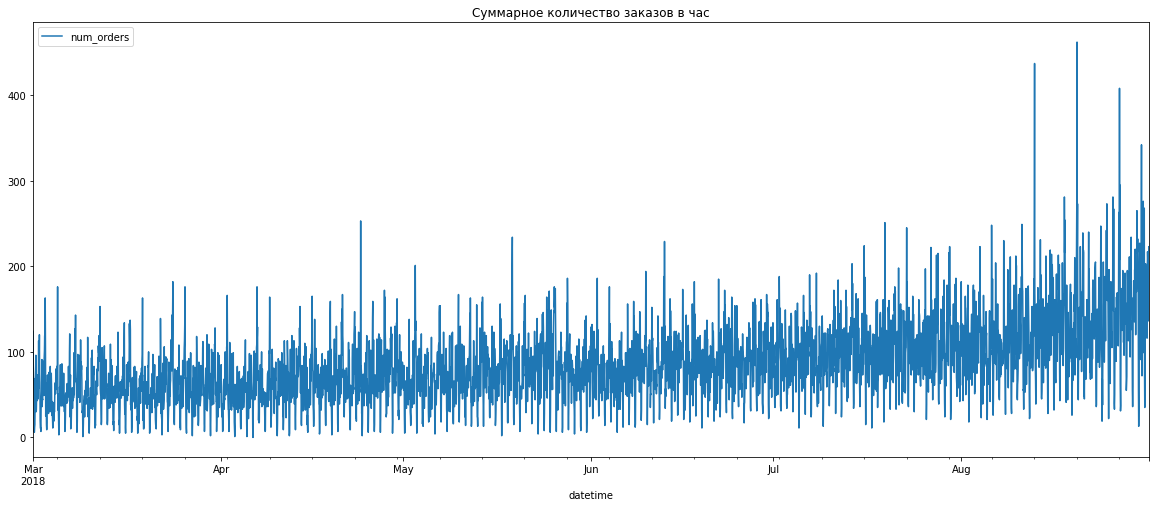

In [61]:
plt.figure(figsize=(20,8))
data.plot(ax = plt.gca())
plt.title('Суммарное количество заказов в час')
plt.show()

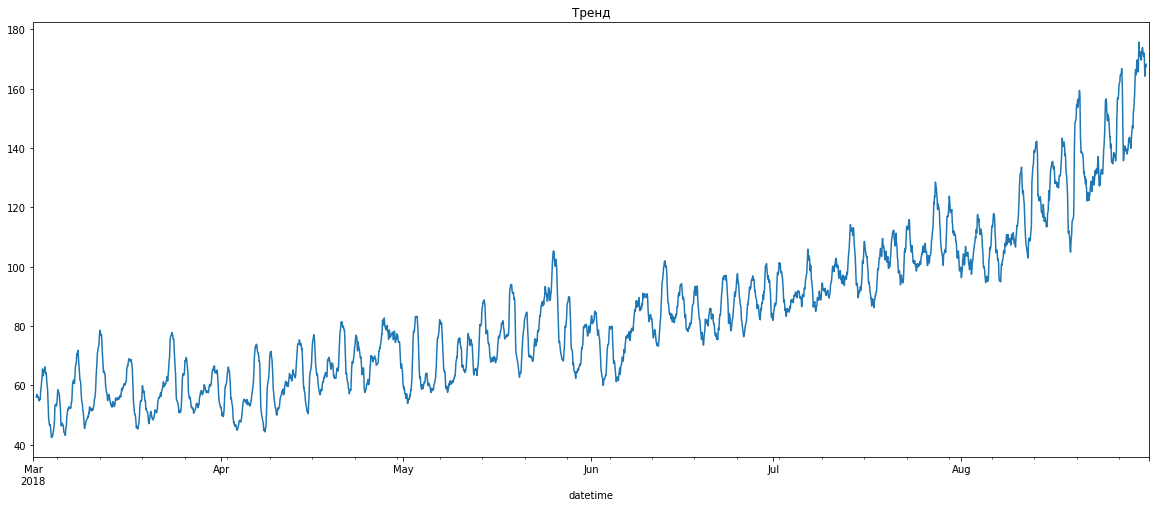

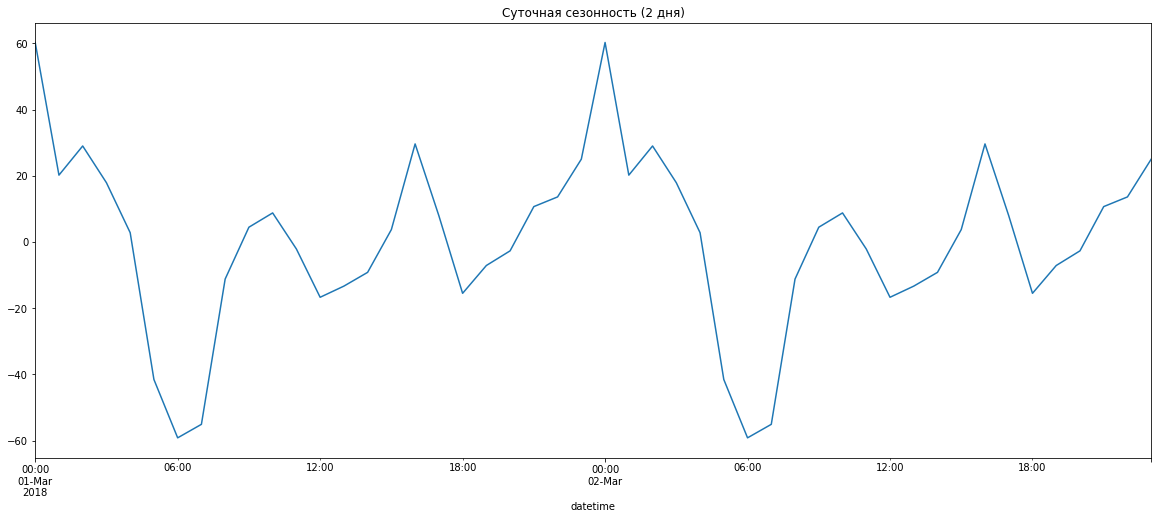

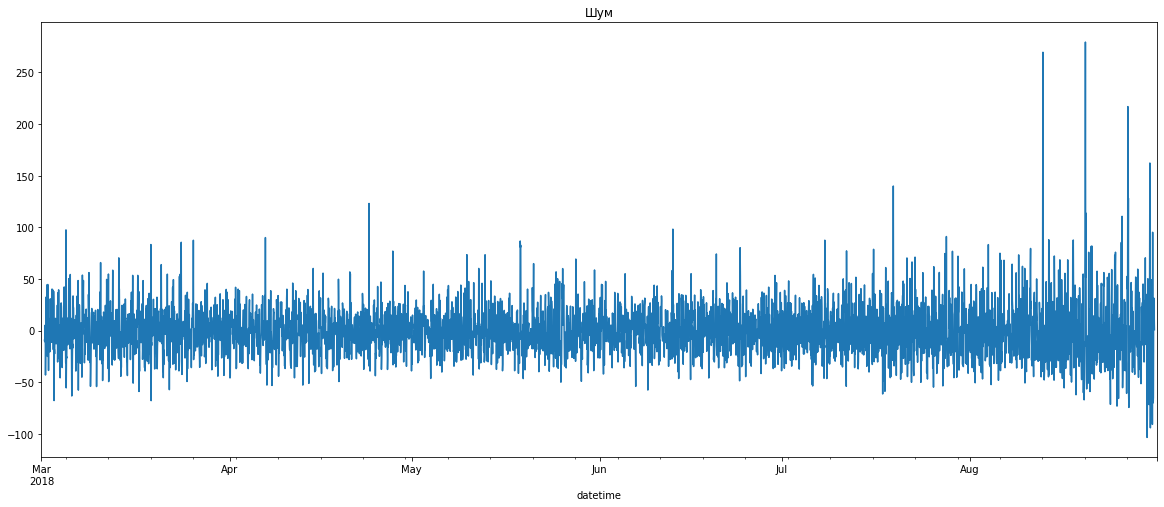

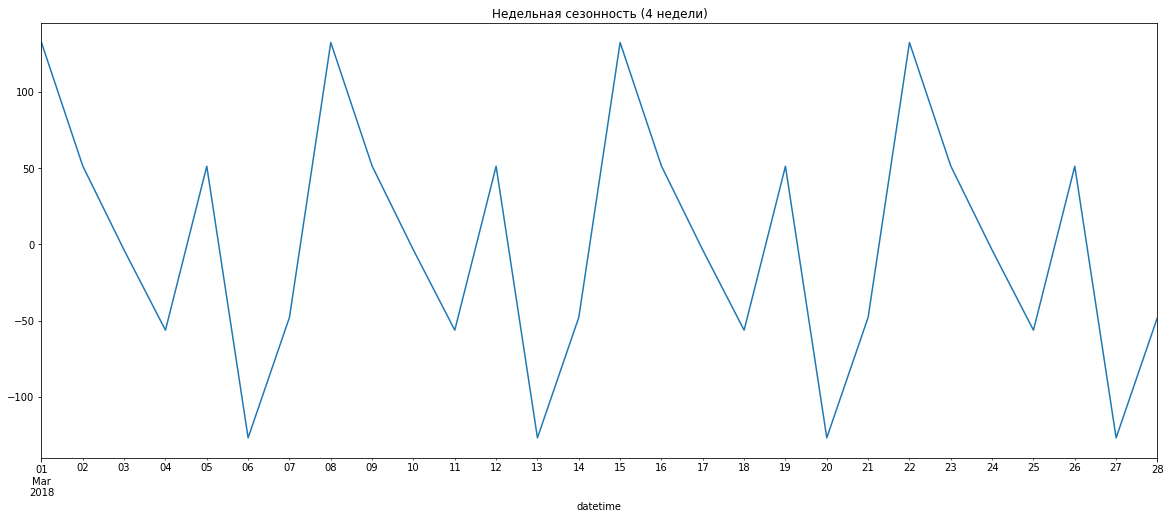

In [62]:
decomposed_data = seasonal_decompose(data)
plt.figure(figsize=(20,8))
decomposed_data.trend.plot(ax = plt.gca())
plt.title('Тренд')
plt.show()

plt.figure(figsize=(20,8))
decomposed_data.seasonal['2018-03-01':'2018-03-02'].plot(ax = plt.gca())
plt.title('Суточная сезонность (2 дня)')
plt.show()

plt.figure(figsize=(20,8))
decomposed_data.resid.plot(ax = plt.gca())
plt.title('Шум')
plt.show()

day_resempled_data = data['2018-03-01':'2018-03-28'].resample('1D').sum()
plt.figure(figsize=(20,8))
seasonal_decompose(day_resempled_data).seasonal.plot(ax = plt.gca())
plt.title('Недельная сезонность (4 недели)')
plt.show()

Мы видим, общий тренд на увеличение количества заказов, выраженные суточные колебания и шум, сравнимый с суточными колебаниями. Данные содержат только период с марта по август 2018 года, поэтому мы не сможем использовать ежегодную сезонность, только суточную и недельную.

## Анализ

На количество заказов такси влияют суточные колебания и недельные колебания, поэтому добавим в датасет значение дня недели, а кроме того значения количества заказов за предыдущие 24 часа и значение скользящего среднего последние 168 часов (неделю), чтобы отследить общий тренд.

In [64]:
def make_features(data, max_lag, rolling_mean_size):
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    lags = []   
    for i in range(max_lag):
        name = 'lag_'+str(i+1)
        lags.append(name)
        data[name] = data['num_orders'].shift(i+1)

    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean().shift(1)
    return lags

In [66]:
lags = make_features(data, 24, 168)
dayofweek_ohe = pd.get_dummies(data['dayofweek'], drop_first=True)
hour_ohe = pd.get_dummies(data['hour'], drop_first=True)
data = data.merge(dayofweek_ohe, on = 'datetime')
data = data.merge(hour_ohe, on = 'datetime')

In [67]:
data = data.dropna()


## Обучение
Разобьём данные на обучающую и тестовую часть, но в обущающей ещё дополнительно выделим валидационную выборку для промежуточного контроля. Мы обучим следующием модели:
- линейную регрессию
- дерево решений
- случайный лес
- модель бустинга с помощью библиотеки CatBoost
- модель бустинга с помощью библиотеки LGBM

In [85]:
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1, random_state = 12345)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.11111111111, random_state = 12345)

In [93]:
target_train = train['num_orders']
features_train = train.drop(['num_orders'], axis = 1)
target_valid = valid['num_orders']
features_valid = valid.drop(['num_orders'], axis = 1)
target_test = test['num_orders']
features_test = test.drop(['num_orders'], axis = 1)
target_train_valid = train_valid['num_orders']
features_train_valid = train_valid.drop(['num_orders'], axis = 1)

print(features_train.shape, target_train.shape, features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(3398, 85) (3398,) (425, 85) (425,) (425, 85) (425,)


In [87]:
lr = LinearRegression()
grid = {}
tscv = TimeSeriesSplit(n_splits=5)
glr = GridSearchCV(lr, cv = tscv, param_grid=grid, scoring=mean_squared_error, n_jobs=-1)
glr.fit(features_train, target_train)
best_model_lr = glr.best_estimator_
predictions_valid = best_model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, predictions_valid)**0.5
print("Линейная регрессия")
print("RMSE валидационной выборки:", rmse_lr)


Линейная регрессия
RMSE валидационной выборки: 32.332149107034304


In [88]:
rfr = RandomForestRegressor(random_state = 12345)
grid = {'n_estimators': (1, 10, 1), 'max_depth': (1,5)}
tscv = TimeSeriesSplit(n_splits=5)
grfr = GridSearchCV(rfr, cv = tscv, param_grid=grid, scoring=mean_squared_error, n_jobs=-1)
grfr.fit(features_train, target_train)
best_model_rfr = grfr.best_estimator_
predictions_valid = best_model_rfr.predict(features_valid)
rmse_rfr = mean_squared_error(target_valid, predictions_valid)**0.5
print('Случайный лес')
print("RMSE валидационной выборки:", rmse_rfr)


Случайный лес
RMSE валидационной выборки: 51.90995880117134


In [89]:
dtr = DecisionTreeRegressor(random_state = 12345)
grid = {'min_samples_split': (2, 5), 'max_depth': (1,10)}
tscv = TimeSeriesSplit(n_splits=5)
gdtr = GridSearchCV(dtr, cv = tscv, param_grid=grid, scoring=mean_squared_error, n_jobs=-1)
gdtr.fit(features_train, target_train)
best_model_dtr = gdtr.best_estimator_
predictions_valid = best_model_dtr.predict(features_valid)
rmse_dtr = mean_squared_error(target_valid, predictions_valid)**0.5
print('Дерево решений')
print("RMSE валидационной выборки:", rmse_dtr)


Дерево решений
RMSE валидационной выборки: 51.63503592190021


In [94]:
initial_columns = ['dayofweek', 'hour', 'rolling_mean'] + lags
features_train_boost = features_train[initial_columns]
features_valid_boost = features_valid[initial_columns]
features_test_boost = features_test[initial_columns]
features_train_valid_boost = features_train_valid[initial_columns]

In [91]:
cat_features = ['dayofweek', 'hour']
cbr = CatBoostRegressor(loss_function="RMSE", iterations=100, depth = 10) 
cbr.fit(features_train_boost, target_train, cat_features = cat_features, verbose=False)
predictions_valid = cbr.predict(features_valid_boost)
rmse_cbr = mean_squared_error(target_valid, predictions_valid)**0.5
print('CatBoost')
print("RMSE валидационной выборки:", rmse_cbr)

CatBoost
RMSE валидационной выборки: 32.06691220065558


In [92]:
for feature in cat_features:
    features_train_boost[feature] = features_train_boost[feature].astype('category')
    features_valid_boost[feature] = features_valid_boost[feature].astype('category')
    features_test_boost[feature] = features_test_boost[feature].astype('category')
    
lgbr = LGBMRegressor(n_estimators = 100, n_jobs=-1)
lgbr.fit(features_train_boost, target_train, verbose=False)
predictions_valid = lgbr.predict(features_valid_boost) 
rmse_lgbr = mean_squared_error(target_valid, predictions_valid)**0.5
print('LGBM')
print("RMSE валидационной выборки:", rmse_lgbr)


LGBM
RMSE валидационной выборки: 30.6174537521225


**Вывод**: Лучший результат на валидационной выборке дали модели **линейной регрессии, CatBoost, LGBM**, остальные модели не дали целевого значения RMSE. Минимальный результат дала модель  **LGBM**, но на тестовой выборке проверим все три.

## Тестирование
Перед тестированием дополнительно дообучим модели бустингов на тренировочной + валидационной выборках)

In [95]:
lgbr.fit(features_train_valid_boost, target_train_valid, verbose=False)
cbr.fit(features_train_valid_boost, target_train_valid, cat_features = cat_features, verbose=False)

In [96]:
predictions_test = best_model_lr.predict(features_test)
rmse_lr_test = mean_squared_error(target_test, predictions_test)**0.5

predictions_test = cbr.predict(features_test_boost)
rmse_cbr_test = mean_squared_error(target_test, predictions_test)**0.5

predictions_test = lgbr.predict(features_test_boost) 
rmse_lgbr_test = mean_squared_error(target_test, predictions_test)**0.5

In [97]:
result = pd.DataFrame(data = [['LinearRegression', rmse_lr, rmse_lr_test],
                              ['RandomForestRegressor', rmse_rfr, '-'],
                              ['DecitionTreeRegressor', rmse_dtr, '-'],
                              ['CatBoostRegressor', rmse_cbr, rmse_cbr_test],
                              ['LGBMRegressor', rmse_lgbr, rmse_lgbr_test]],
                      columns = ['Model', 'RMSE_valid', 'RMSE_test'])

In [98]:
display(result)

,Model,RMSE_valid,RMSE_test
0,LinearRegression,32.332149,42.239177
1,RandomForestRegressor,51.909959,-
2,DecitionTreeRegressor,51.635036,-
3,CatBoostRegressor,32.066912,46.920433
4,LGBMRegressor,30.617454,41.635862


На валидационной выборке три модели (линейная регрессия и бустинги) дали схожие результаты. Модели бустингов мы дополнительно дообучили на валидационной выборке, после чего все три модели также прошли финальное тестирование.